# Contact segmentation in 2d

Author(s): Jukka Aho

**Abstract**: Contact segmentation in 2d

In [1]:
using JuliaFEM: PSeg, get_field, set_field, interpolate, new_field!, push_field!
using JuliaFEM: calculate_normals!, average_normals!, fit_derivative_field!
using JuliaFEM: set_degree, get_number_of_basis_functions, dinterpolate
using PyPlot

Create some test boundaries

In [2]:
srand(42)

nsl = 5
nm = 5

x1 = linspace(0, 3, nsl) + rand(nsl)*0.1
y1 = 0.5*rand(nsl)
x2 = linspace(0, 3, nm) + rand(nm)*0.1 + 0.4
y2 = 0.5*rand(nm) + 0.5

function create_elements(X, sid=0)
    Γ = []
    nnodes = size(X, 2)
    nelements = nnodes-1
    for i=1:nelements
        con = sid+[i, i+1]
        el = PSeg(con)
        set_field(el, :Geometry, Vector[X[:, i], X[:, i+1]])
        push!(Γ, el)
    end
    return Γ
end
Γ₁ = create_elements([x1 y1]', 0)
Γ₂ = create_elements([x2 y2]', nsl);

# calculate and average normals like se did in last notebook
for el in [Γ₁; Γ₂]
    calculate_normals!(el)
end
average_normals!(Γ₁)
average_normals!(Γ₂)

In [3]:
""" Find projection from slave nodes to master element. """
function calc_projection_slave_nodes_to_master_element(sel, mel)
    X1 = get_field(sel, :Geometry)
    N1 = get_field(sel, :Normals)
    X2(xi) = interpolate(mel, :Geometry, xi)
    dX2(xi) = dinterpolate(mel, :Geometry, xi)
    R(xi, k) = det([X2(xi) - X1[k] N1[k]]')
    dR(xi, k) = det([dX2(xi) N1[k]]')
    xi2 = Vector[[0.0], [0.0]]
    for k=1:2
        xi = xi2[k]
        for i=1:3
            dxi = -R(xi, k)/dR(xi, k)
            xi += dxi
            if abs(dxi) < 1.0e-9
                break
            end
        end
        xi2[k] = xi
    end
    clamp!(xi2, -1, 1)
    return xi2
end

""" Find projection from master nodes to slave element. """
function calc_projection_master_nodes_to_slave_element(sel, mel)
    X1(xi) = interpolate(sel, :Geometry, xi)
    dX1(xi) = dinterpolate(sel, :Geometry, xi)
    N1(xi) = interpolate(sel, :Normals, xi)
    dN1(xi) = dinterpolate(sel, :Normals, xi)
    X2 = get_field(mel, :Geometry)
    R(xi, k) = det([X1(xi) - X2[k] N1(xi)]')
    dR(xi, k) = det([dX1(xi) N1(xi)]') + det([X1(xi) - X2[k] dN1(xi)]')
    xi1 = Vector[[0.0], [0.0]]
    for k=1:2
        xi = xi1[k]
        for i=1:3
            dxi = -R(xi, k)/dR(xi, k)
            xi += dxi
            if abs(dxi) < 1.0e-9
                break
            end
        end
        xi1[k] = xi
    end
    clamp!(xi1, -1, 1)
    return xi1
end

function has_projection(sel, mel)
    xi1 = calc_projection_master_nodes_to_slave_element(sel, mel)
    l = abs(xi1[2]-xi1[1])[1]
    return l > 1.0e-9
end

function calc_projection(sel, mel)
    xi1 = calc_projection_master_nodes_to_slave_element(sel, mel)
    xi2 = calc_projection_slave_nodes_to_master_element(sel, mel)
    return xi1, xi2
end

calc_projection (generic function with 1 method)

Visualize results

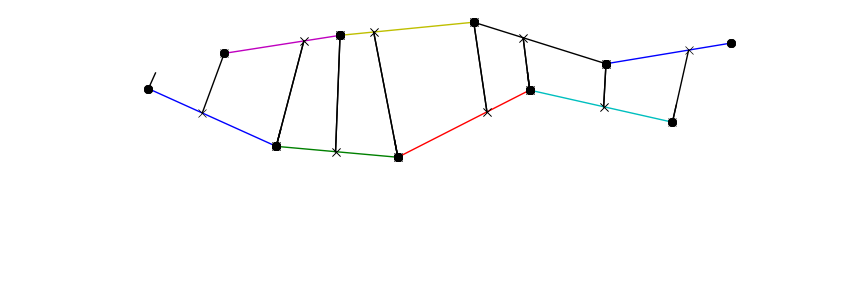

(-0.5,4.0)

In [4]:
function plot_element(el; plot_with_normal=false)
    # create a array of vectors
    xis = Vector[[xi] for xi in linspace(-1, 1)]
    coords = interpolate(el, :Geometry, xis)
    normals = interpolate(el, :Normals, Vector[[-1.0], [1.0]])
    ncoords = interpolate(el, :Geometry, Vector[[-1.0], [1.0]])
    xs = [X[1] for X in coords]
    ys = [X[2] for X in coords]
    plot(xs, ys, "-")
    plot([xs[1], xs[end]], [ys[1], ys[end]], "ko")
    plot([xs[1], xs[end]], [ys[1], ys[end]], "ko")
    if plot_with_normal
        for i=1:2
            p0 = ncoords[i]
            p1 = ncoords[i]+0.1*normals[i]
            plot([p0[1], p1[1]], [p0[2], p1[2]], "-k")
        end
    end
end

function plot_all()
    figure(figsize=(10, 3))
    for el in Γ₁
        plot_element(el; plot_with_normal=true)
    end
    for el in Γ₂
        plot_element(el; plot_with_normal=false)
    end
    for sel in Γ₁
        for mel in Γ₂
            if has_projection(sel, mel)
                xi1, xi2 = calc_projection(sel, mel)
                X1 = interpolate(sel, :Geometry, xi1)
                X2 = interpolate(mel, :Geometry, xi2)
                #println("$X1\n\n$X2")
                for s=1:2
                    plot([X1[s][1], X2[s][1]], [X1[s][2], X2[s][2]], "-kx")
                end
            end
        end
    end
    axis("equal")
    axis("off")
    ylim(-0.0, 0.5)
    xlim(-0.5, 4.0)
end

plot_all()

A little experience, raise the degree of elements, smooth geometry, and test projection for 2nd order:

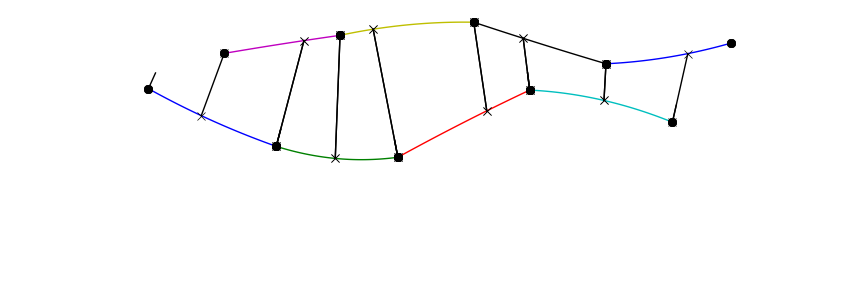

(-0.5,4.0)

In [5]:
# to raise degree of elements and smooth geometry
function tangent(el, xi)
    normal = interpolate(el, :Normals, xi)
    [0 -1; 1 0]'*normal
end
for el in [Γ₁; Γ₂]
    set_degree(el, 2)
    for field in (:Geometry, :Normals)
        push!(el.fields[field], [0.0, 0.0])
        el.fields[field] = el.fields[field][1:get_number_of_basis_functions(el)]
    end
end
for el in [Γ₁; Γ₂]
    fit_derivative_field!(el, :Geometry, tangent, Int[1, 2])
end
plot_all()